In [2]:
import sys
import os

# modify syspath directory to sys.path

package_path = os.path.abspath(os.path.join('..','core'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..','utils'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..'))
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt

from IPython.display import HTML # both needed to disply gifs
from PIL import Image

# Import modules from the package
from core import create_hamiltonian as ch
from core import create_state as cs
from core import create_coherent_state
from core import time_evo
from core import time_evo_new
from core import time_evo_from_state
from core import load_param
from core import load_H_list
from core import load_result
from core import load_tlist
from core import operators
from core.schmidt_solve import compute_schmidt_states_all_time
from core.eigen_ener_states import eigen_ener_states as eig
from core import annihilation_operator
from utils.entropy import compute_VN, plot_VN, compute_VN_time
from utils import collapse_gif
from utils.collapse_gif import collapse_gif
from utils.display_gif import display_gif
from utils.distribution_gif import gif_distribution_eig_total
from utils.distribution_gif import prob_gif
from utils.distribution_gif import gif_distrib_H_s_int
from utils.plot import plot_basic
from utils.plot import plot_with_binning
from utils.basic_functions import state_distribution_eig_tot
from utils.basic_functions import random_dephasing
from utils.basic_functions import get_state_probabilities
from utils.overlap import overlap
from utils.overlap import gif_schmidt_overlap
from utils.interference import interference_plot
from utils.expectations import exp_val_time
from utils.plot_hamiltonians import plot_hamiltonians



<h1/>The ACL model<h1/>

The ACL model is model of **decoherence**, adapted from the Caldeira-Leggett model. It simplifies it by keeping the strict minimum to achieve decoherence while making it numerically practical. 
The ACL model, models a Hamiltonian, of the form 
\begin{equation}    
    H_{tot}=H_s+H_e+H_I
\end{equation}
in a Hilbert space composed of a system $\mathcal{S}$ and an environment $\mathcal{E}$. <br>

The system is a truncated simple harmonic oscillator (SHO), who's self Hamiltonian is defined by $H_s=H_{SHO}\otimes\mathbb{1}$, with $H_{SHO}$ the Hamiltonian of a simple truncated simple harmonic oscillator.
The interaction term is given by $H_I=X\otimes H^e_I$ with $H^e_I=E_IH_r+E^0_I$ and $X$ the position operator and $H_r$ is a random matrix. This makes the interaction strenght dependant on the position, and various positions get entangled with different environment states. The environment self Hamiltonian is given by $H_e=E_eH_r'+E^0_e$, with $H_r$ another random matrix. The total Hamiltonian is constant during the whole time evolution. 

He and HeI are independant random matrices to decohere with maximal efficiency, shortening the simulation time needed to get results. (In the CL model the environment is a boson bath.)



Why the ACL model? 


Caldeira-Leggett (CL) model is a toy model describing a particle which moves in its own potential and is also coupled to an environment
The environment is usually treated as an infinite set of harmonic oscillators, and the particle is often taken to move in a harmonic potential as well.

The adaptsations reproduce the essential features of the CL model within a finit Hilbert space. This allows for numerical exploration outside of the markovian limit (where we treat the system using a master equation.). We thus obtain results for unitary QM.

one thing we cant get with a master equation is a fully fluctuating equilibrium state. important in studying AoT and einselection relationship.

paper introducting the ACL model: 


Coherent states are the classical equivalent of states of an oscillator. not the energy eigenstates. So i need to show that coherent states are the pointer states/show collapse for my simulation.


talk about specifics of the architechture of the package I am working on. ie, save outputes of simulations and have the framework to retreive it all in a convenient ways. All functions take bit data and work themselfs to recover what matters from theis data on its own.



Specifically in the code, with parameter in green, the model takes the following form, INCORECT HAS BEEN CHANGED NOW!!!
$$H = H_s + H_{int} + H_e = H_{s\_ self} \otimes id + H_{int\_ s} \otimes H_{int\_ e} + id \otimes H_{e\_ self}$$
$$ = [{\color{ForestGreen}E_s} \otimes diag(i)\otimes id(d_2) + {\color{ForestGreen}E_{s2}} \otimes id(d_1)\otimes id(d_2) ] + [{\color{ForestGreen}(E_{int\_ s}} \otimes offdiag(\sqrt{i}) + {\color{ForestGreen}E_{int\_ s2}} \otimes diag(i)) \otimes ({\color{ForestGreen}E_{int\_ e}} \otimes rd(d_2) + {\color{ForestGreen}E_{int\_ e2}} \otimes id(d_2))] + [id(d_1) \otimes ({\color{ForestGreen}E_e} \otimes H_{e\_ self} + {\color{ForestGreen}E_{e2}} \otimes id(d_2))]$$


Finally this leaves us with the following parameters defining the model. 
E_e and E_I are c numbers responsible for the relative strenght between system-env interaction, systyem self interaction and environment self interaction.
E^0_e and E^0_I are real numbers responsible for energy scale of the environment and interaction Hamiltonian.


Done here: 
we demonstrate the ACL model reproduces decoherence: simple deco results/visualization SHO

We demonstrate the possibility of re-deriving known results using the ACL model. ACL paper. Thermalization paper. cosmo paper.

We demonstrate its usefulness in exploring new avenues of research: my various new research directions from it, ie splitting. energy conservation in branches.

We demonstrate its flexibility in simulating a host of simple decoherence model, taylored for every needs. Show differences between the various models.

Based on subsystems paper, recover the 3 regimes of the ACL model described in there.

Usefulness of studying decoherence: studying/better understanding noise. Arrow of time. Cosmology .... add references for this. use the references to justify the work, but also the need for various options I am adding.

BLock diagonal stuff

Taking the eigenstates of $H_q$ to be $\{|q_i\rangle\}\forall$, there is a basis like $\{|q_i\rangle|k(q_i)\rangle\}$, such that $H_{tot}$, $H_e$ and $H_I$ take the a block diagonal form. $i\in[0,d_1-1],j\in [0,d_2-1]$, $d_1$ and $d_2$ the dimensions of the system and environment respectively, giving a total dimension $d=d_1*d_2$.

<h1>Pure ACL<h1>

<h3>Harmonic oscillator behavior with a coherent state<h3>

In [3]:
path="../outputs/gifs/distrib_in_H_int_s_gif_coherent_state_notebook.gif"
display_gif(path)

<h3>Cat states + visible interference<h3>

In [4]:
path="../outputs/gifs/distrib_in_H_int_s_gif_coherent_state_superposition.gif"
display_gif(path)

<img src="outputs/temp/interference_superposition.jpg" width="1001">


<h3>Cat state and einselection<h3>
<h5>We plot the top 2 eigenstates of $\rho_s$<h5>

<h3>Entropy<h3>

/Users/maringirard/Dev/ACL/utils/entropy.py:10: RuntimeWarning: divide by zero encountered in log2
  entropy = -np.sum(np.nan_to_num(np.log2(np.linalg.eigvals(density_matrix.full())) * np.linalg.eigvals(density_matrix.full())))
/Users/maringirard/Dev/ACL/utils/entropy.py:10: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(np.nan_to_num(np.log2(np.linalg.eigvals(density_matrix.full())) * np.linalg.eigvals(density_matrix.full())))
/usr/local/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


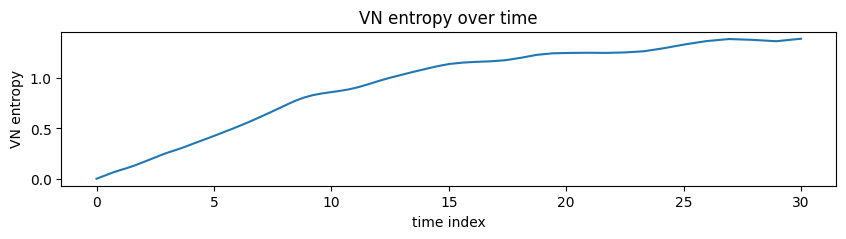

In [6]:
file_name = "coherent_state_notebook"

d1, d2, E_s, E_s2, E_int_s, E_int_e, E_int_s2, E_int_e2, E_e, E_e2, envi, tmax, ind_nb, log = load_param(file_name)
info = load_param(file_name)
H_list=load_H_list(file_name)
result=load_result(file_name)
tlist=load_tlist(file_name)

plot_VN(result,tlist)

<h1>An even simpler decoherence model<h1>

<h3>Einselection <h3>

<h3>Exploring the role of decoherence in einselection<h3>

In [ ]:

eigenenergies_system_2, eigenstates_system_2 = H_list[7].eigenstates() 
eigenenergies_system_total, eigenstates_system_total = H_list[1].eigenstates() 
eigenenergies_system_1, eigenstates_system_1 = H_list[6].eigenstates() 

# Plot 2: Distribution of the Environment state over the environment energy eigenstates
time_index = 10  # Define the time index
s0 = compute_schmidt_states(result, time_index, 1)[0]
schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_2]
plt.plot(eigenenergies_system_2, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_2}')

    


In [ ]:
    # Plot 3: Distribution of the System state over the system energy eigenstates
    s0 = compute_schmidt_states(result, time_index, 0)[0]
    schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_1]
    plt.plot(eigenenergies_system_1, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_1}')
    #axes[1, 0].set_title("Distribution of the System state over the system energy eigenstates")
    #axes[1, 0].set_xlabel("Energy Eigenstates")
    #axes[1, 0].set_ylabel("Schmidt Coefficients")
    plt.show()
    # Plot 4: Distribution of the state over the energy eigenstates
    s0 = result.states[0]
    schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates_system_total]
    plt.plot(eigenenergies_system_total, schmidt_coefficients0, marker='o', label=f'Energy {eigenenergies_system_total}')
    #axes[1, 1].set_title("Distribution of the state over the energy eigenstates")
    #axes[1, 1].set_xlabel("Energy Eigenstates")
    #axes[1, 1].set_ylabel("Schmidt Coefficients")
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

<h1>The various models</h1>

We start with the simplest possible decoherence model, which as we see in the gif displays apparent collapse

In [ ]:
#To get a very clear collapse, we choose the following parameters.
#Essentially, weare making the system interactio a diagonal matrix, ie interaction depends on coherent states.
#H = [(E_s x diag(i) + E_s2 x id)x id ] + [(E_int_s x off_diag_sqrt(i) + E_int_s2 x id) x (E_int_e x rd_mat1 + E_int_e2 x id)] + [id x (E_e x H_e_self + E_e2 x id)]
d1=10;d2=200;E_s=1; E_s2=0; E_int_s=0; E_int_e=1;E_int_s2=0.06;E_int_e2=0; E_e=1; E_e2=0;w=[0,0,0,np.sqrt(0.3),0,0,0,np.sqrt(0.7),0,0];envi=[0]; tmax= 10; ind_nb = 100;log=0

# Running the simulation and running the core functions

result, tlist, H_list, ket_list, info = time_evo_new(d1,d2,E_s,E_s2,E_int_s,E_int_e,E_int_s2,E_int_e2,E_e,E_e2,w,envi,tmax,ind_nb,log)
eigen = eig(H_list)
s_list = compute_schmidt_states_all_time(result, ind_nb)
ss_list = s_list[0]
se_list= s_list[1]
sv_list = s_list[2]
s_full_list=s_list[3]
plot_hamiltonians(H_list)
gif_path = collapse_gif(eigen, s_list, info)
display_gif(gif_path)
